In [1]:
import os
import shutil
import time
import json

In [2]:
import keras
import matplotlib.pyplot as plt
import tensorflow as tf
from keras import layers, Sequential
from keras.src.applications.convnext import ConvNeXtXLarge
from keras.src.applications.efficientnet_v2 import EfficientNetV2L
from keras.src.applications.inception_resnet_v2 import InceptionResNetV2
from keras.src.applications.resnet_v2 import ResNet50V2
from keras.src.applications.vgg16 import VGG16
from keras.src.applications.xception import Xception
from keras.src.callbacks import ModelCheckpoint, EarlyStopping
from keras.src.utils import image_dataset_from_directory
from pandas import DataFrame
from plot_keras_history import show_history

2024-09-16 10:32:53.065992: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-16 10:32:53.077877: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-16 10:32:53.081629: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-16 10:32:53.091974: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-16 10:32:53.941471: W tensorflow/compiler/tf2

In [3]:
CROPPED_IMAGES_PATH = "resources/Cropped_Images"
MODELS_PATH = "models/transfer_learning"

In [4]:
def remove_last_generated_models():
    shutil.rmtree(MODELS_PATH, ignore_errors=True)
    os.makedirs(MODELS_PATH)

In [5]:
def get_dataset(path, image_size, validation_split=0.0, data_type=None):
    return image_dataset_from_directory(
        path,
        labels='inferred',
        label_mode='categorical',
        class_names=None,
        batch_size=batch_size,
        image_size=image_size,
        seed=42,
        validation_split=validation_split,
        subset=data_type
    )

In [6]:
def create_model(image_size, base_model):
    for layer in base_model.layers:
        layer.trainable = False
    data_augmentation_layers = Sequential([
        layers.RandomFlip("horizontal", input_shape=image_size + (3,)),
        layers.RandomRotation(0.1)
    ])
    model = Sequential([
        # Data preparation
        data_augmentation_layers,
        layers.Rescaling(1. / 127.5, offset=-1),

        # Pre-trained model without the top
        base_model,

        # Convert the feature map from the encoder part of the model (without the top) to a vector
        layers.GlobalAveragePooling2D(),

        # Fully connected layers (all neurons are linked to the others).
        layers.Dense(256, activation='relu'),

        # Dropout layer to prevent overfitting. Randomly stops some neurons for each image so that the other neurons have to adapt to that, to reduce overfitting.
        # Not the latest method to do this, batch normalization for example is better. Check more online.
        layers.Dropout(0.5),

        # Output layer with the same layer as your labels. Softmax to allow the model to predict the probability of each class.
        layers.Dense(120, activation='softmax')
    ])

    # Crossentropy as we're getting closer to a correct prediction of the labels.
    model.compile(loss="categorical_crossentropy", optimizer='adam', metrics=["accuracy"])

    # print(model.summary())
    return model

In [7]:
def get_base_model(base_model, image_size):
    input_shape = image_size + (3,)
    preprocessing_input = keras.layers.Input([224, 224, 3])
    
    match base_model:
        case "VGG16":
            return (VGG16(include_top=False, weights="imagenet", input_shape=input_shape,
                          input_tensor=keras.applications.vgg16.preprocess_input(preprocessing_input)))
        case "Xception":
            return (Xception(include_top=False, weights="imagenet", input_shape=input_shape,
                             input_tensor=keras.applications.xception.preprocess_input(preprocessing_input)))
        case "ResNet50V2":
            return (ResNet50V2(include_top=False, weights="imagenet", input_shape=input_shape,
                               input_tensor=keras.applications.resnet_v2.preprocess_input(preprocessing_input)))
        case "InceptionResNetV2":
            return (InceptionResNetV2(include_top=False, weights="imagenet", input_shape=input_shape,
                                      input_tensor=keras.applications.inception_resnet_v2.preprocess_input(
                                          preprocessing_input)))
        case "EfficientNetV2L":
            # The preprocessing logic has been included in the EfficientNetV2 model implementation.
            return EfficientNetV2L(include_top=False, weights="imagenet", input_shape=input_shape)
        case "ConvNeXtXLarge":
            # The preprocessing logic has been included in the convnext model implementation.
            return ConvNeXtXLarge(include_top=False, weights="imagenet", input_shape=input_shape)
        case _:
            return None

In [8]:
def display_results_plots(results):
    display_results_plot(results, ["fitting_time"], "fitting_time")
    display_results_plot(results, ["test_accuracy", "val_accuracy"], "accuracies", ascending=False)
    display_results_plot(results, ["test_loss", "val_loss"], "losses")

In [9]:
def display_results_plot(results, metrics, metrics_name, ascending=True):
    results.sort_values(metrics[0], ascending=ascending, inplace=True)

    performance_plot = (results[metrics + ["model_name"]]
                        .plot(kind="line", x="model_name", figsize=(15, 8), rot=0,
                              title=f"Models Sorted by {metrics_name}"))
    performance_plot.title.set_size(20)
    performance_plot.set_xticks(range(0, len(results)))
    performance_plot.set(xlabel=None)

    plt.show()
    plt.close()

Starting transfer learning script.

Found 20580 files belonging to 120 classes.
Using 15435 files for training.


I0000 00:00:1726457575.939066   64982 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1726457575.987028   64982 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1726457575.989887   64982 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1726457575.993769   64982 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

Found 20580 files belonging to 120 classes.
Using 5145 files for validation.
Found 20580 files belonging to 120 classes.
Displaying all results.



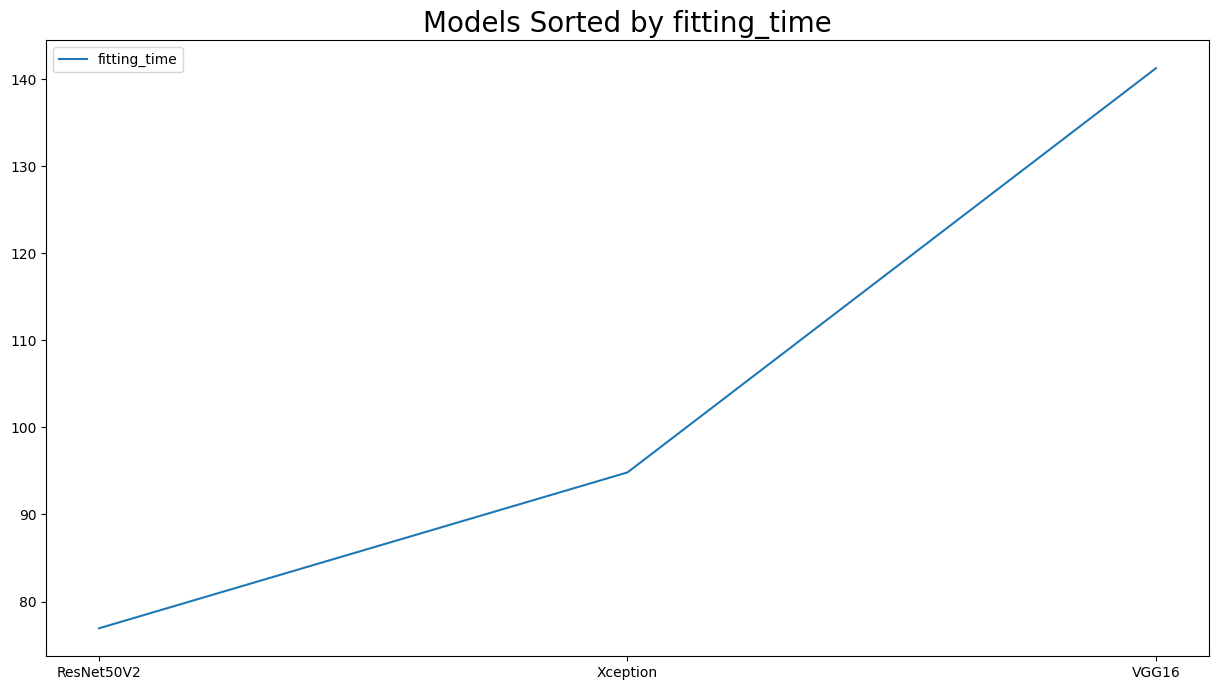

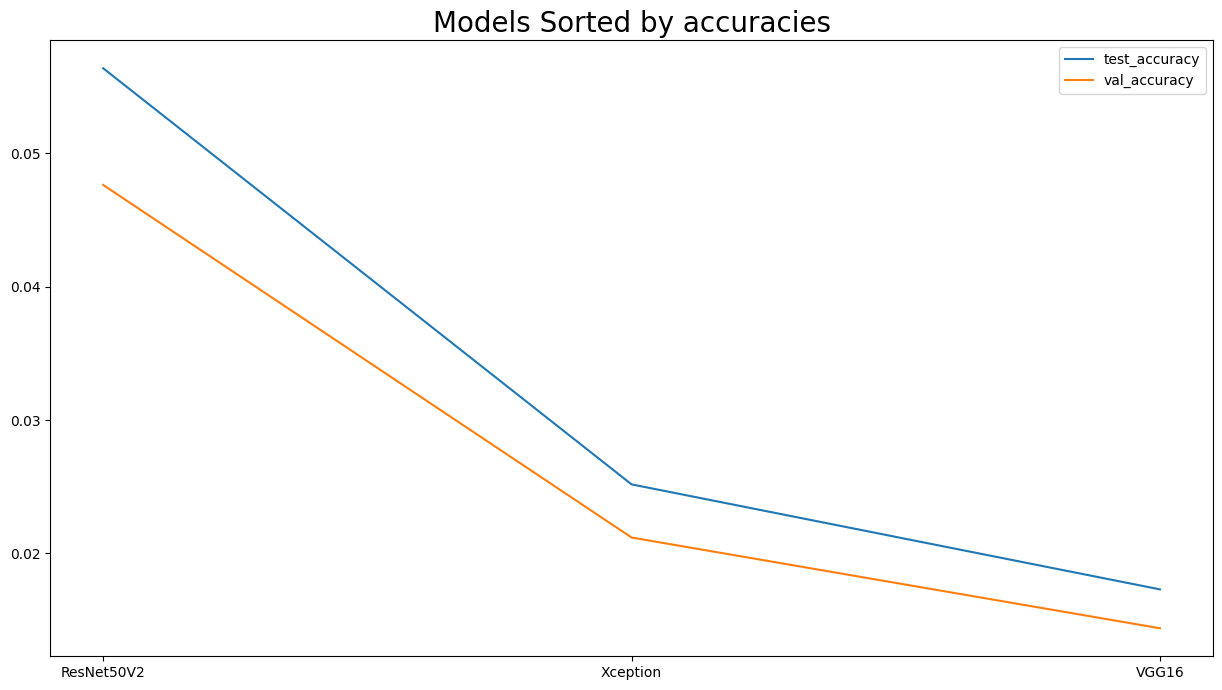

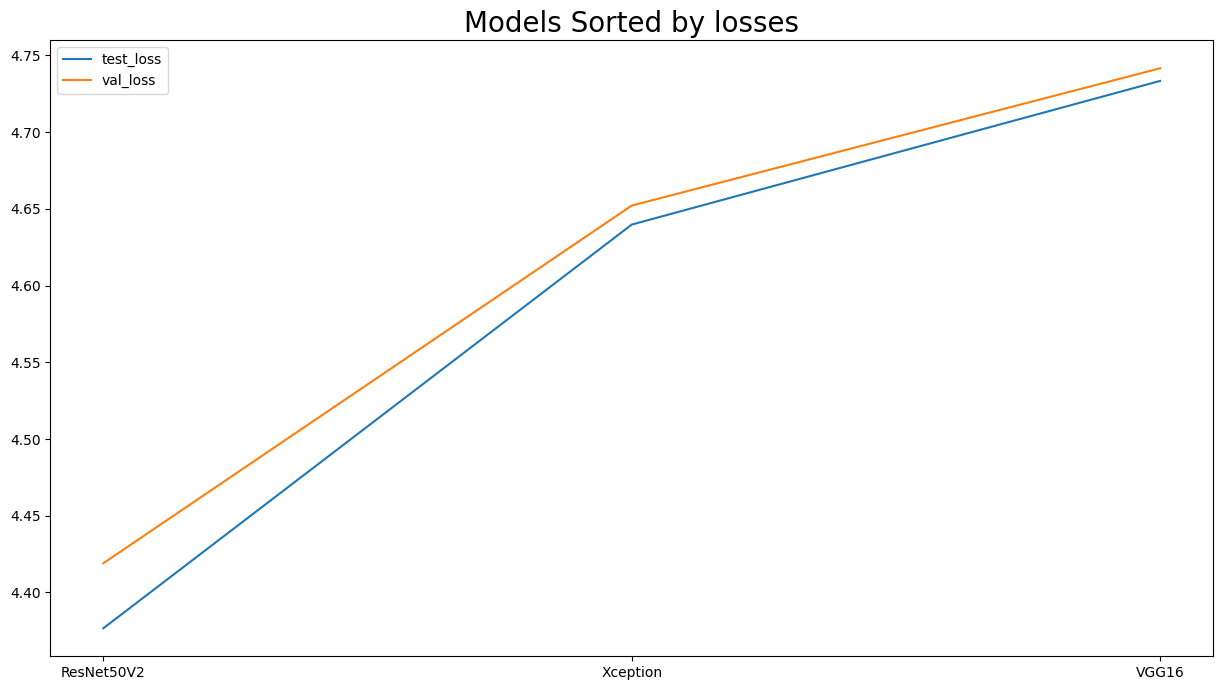

The transfer learning script is now finished.



In [10]:
print("Starting transfer learning script.\n")
remove_last_generated_models()

image_size = (224, 224)
batch_size = 32

dataset_train = get_dataset(CROPPED_IMAGES_PATH, image_size, validation_split=0.25, data_type='training')
dataset_val = get_dataset(CROPPED_IMAGES_PATH, image_size, validation_split=0.25, data_type='validation')
dataset_test = get_dataset(CROPPED_IMAGES_PATH, image_size, data_type=None)

with tf.device('/gpu:0'):
    histories = []
    results = []
    
    for model_name in [
        "VGG16",
        "Xception",
        "ResNet50V2",
        "InceptionResNetV2",
        "EfficientNetV2L",
        "ConvNeXtXLarge"
    ]:
        print(f"Training model {model_name}.\n")

        base_model = get_base_model(model_name, image_size)

        model = create_model(image_size, base_model)
        model_save_path = f"{MODELS_PATH}/{model_name}_best_weights.keras"

        checkpoint = ModelCheckpoint(model_save_path, monitor='val_loss', verbose=1, save_best_only=True,
                                     mode='min')
        es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
        callbacks_list = [checkpoint, es]

        fitting_start_time = time.time()
        history = model.fit(dataset_train,
                            validation_data=dataset_val,
                            batch_size=batch_size,
                            # epochs=2,  # Test value
                            epochs=100,  # We want early stopping to stop the training itself
                            callbacks=callbacks_list,
                            verbose=1)
        fitting_time = time.time() - fitting_start_time

        histories.append(history)
        print("The model has been fitted, checking their loss and accuracy.\n")

        # Getting optimal epoch weights
        model.load_weights(model_save_path)

        val_loss, val_accuracy = model.evaluate(dataset_val, verbose=False)
        print(f"\nValidation Accuracy:{val_accuracy}.\n")

        test_loss, test_accuracy = model.evaluate(dataset_test, verbose=False)
        print(f"\nTest Accuracy:{test_accuracy}.\n")

        results.append({
            "model_name": model_name,
            "fitting_time": fitting_time,
            "test_accuracy": test_accuracy,
            "test_loss": test_loss,
            "val_accuracy": val_accuracy,
            "val_loss": val_loss
        })

        show_history(history)
        plt.close()
    
    print("Displaying all results.\n")
    display_results_plots(DataFrame(results))

print("The transfer learning script is now finished.\n")